## Tehtävä: Oppimisprojekti 2: Kuvantunnistus omilla kuvilla

Tämän projektin tavoitteena on suunnitella ja toteuttaa kuvantunnistusjärjestelmä käyttäen itse otettuja kuvia. Projekti toteutetaan vaiheittain hyödyntäen eri konvoluutioneuroverkkomenetelmiä yksinkertaisesta edistyneempään.

#### Datankäsittely

In [3]:
import os

from PIL import Image
from tensorflow.keras.preprocessing import image_dataset_from_directory

image_folder = '../week2_photodata/'

train_dataset = image_dataset_from_directory(
    image_folder+'train',
    labels='inferred',
    label_mode='categorical',
    image_size=(100,100),
    batch_size=4
)

test_dataset = image_dataset_from_directory(
    image_folder+'test',
    labels='inferred',
    label_mode='categorical',
    image_size=(100,100)
)

validation_dataset = image_dataset_from_directory(
    image_folder+'validation',
    labels='inferred',
    label_mode='categorical',
    image_size=(100,100),
    shuffle=True
)
   
for images, labels in test_dataset:
    print(f"Batch of images shape: {images.shape}")

Found 180 files belonging to 4 classes.
Found 40 files belonging to 4 classes.
Found 40 files belonging to 4 classes.
Batch of images shape: (32, 100, 100, 3)
Batch of images shape: (8, 100, 100, 3)


2025-04-03 00:21:26.293342: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
from keras import Sequential, layers, regularizers
from keras.optimizers import Adam

model = Sequential([
    layers.Input(shape=(100, 100, 3)),
    layers.Rescaling(scale=1./255),

    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.02)),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(4, activation='softmax')
])


model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 98, 98, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 98, 98, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 47, 47, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 47, 47, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │       135,428 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,204 (606.27 KB)

 Trainable params: 155,012 (605.52 KB)

 Non-trainable params: 192 (768.00 B)

In [5]:
import keras

# EarlyStopping callback to stop training when validation loss stops improving
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau callback to reduce the learning rate when validation loss plateaus
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

In [6]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping])

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.5980 - loss: 2.1583 - val_accuracy: 0.2500 - val_loss: 1.8631
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9543 - loss: 0.6152 - val_accuracy: 0.4000 - val_loss: 1.7378
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.9940 - loss: 0.5296 - val_accuracy: 0.6250 - val_loss: 1.5528
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9954 - loss: 0.5016 - val_accuracy: 0.7000 - val_loss: 1.4143
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 1.0000 - loss: 0.4734 - val_accuracy: 0.7750 - val_loss: 1.2491
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.9979 - loss: 0.4605 - val_accuracy: 0.8250 - val_loss: 1.1107
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 1.0000 - loss: 0.4545 - val_accuracy: 0.8250 - val_loss: 1.0482
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 1.0000 - loss: 0.4340 - val_acc

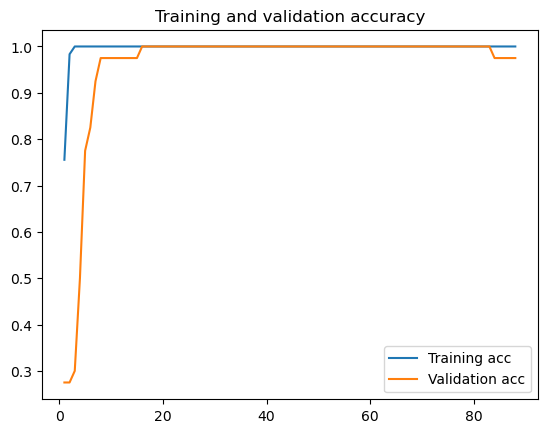

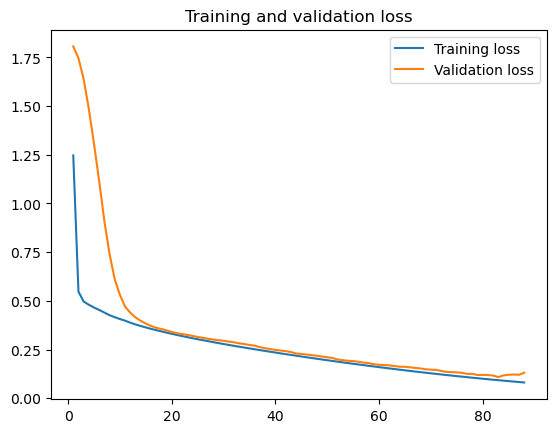

In [7]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [8]:
test_scores = model.evaluate(test_dataset, verbose=0)
print(f"Test loss: {test_scores[0]:.2f}")
print(f"Test accuracy: {test_scores[1]:.2f}")

Test loss: 0.20
Test accuracy: 0.95


In [9]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

# Load the VGG16 model, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(4, activation='softmax')(x)

# Create the new model
model_vgg16 = Model(inputs=base_model.input, outputs=x)

# Compile the model
model_vgg16.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model_vgg16.summary()

# Train the model
history_vgg16 = model_vgg16.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
test_scores_vgg16 = model_vgg16.evaluate(test_dataset, verbose=0)
print(f"VGG16 Test loss: {test_scores_vgg16[0]:.2f}")
print(f"VGG16 Test accuracy: {test_scores_vgg16[1]:.2f}")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,895,620 (60.64 MB)

 Trainable params: 1,180,932 (4.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.6340 - loss: 4.3437 - val_accuracy: 0.9750 - val_loss: 0.3948 - learning_rate: 1.0000e-04
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.9944 - loss: 0.0072 - val_accuracy: 0.9750 - val_loss: 0.3151 - learning_rate: 1.0000e-04
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 1.0000 - loss: 7.1470e-06 - val_accuracy: 0.9750 - val_loss: 0.3176 - learning_rate: 1.0000e-04
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 1.0000 - loss: 2.4431e-06 - val_accuracy: 0.9750 - val_loss: 0.3178 - learning_rate: 1.0000e-04
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 2.7247e-06
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 1.0000 - loss: 2.8869e-06 - val_accuracy: 0.9750 - val_loss: 0.3177 - learning_rate: 1.0000e-04
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - 

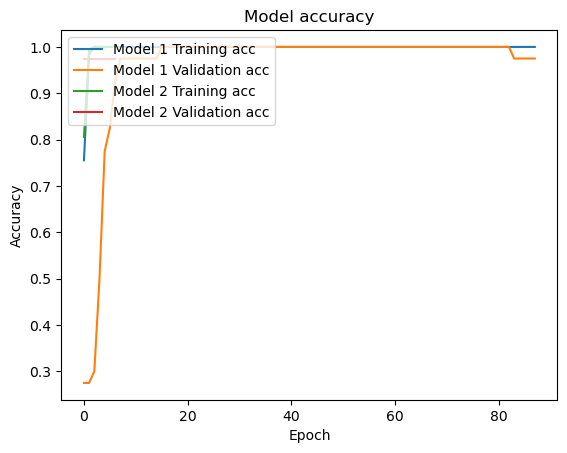

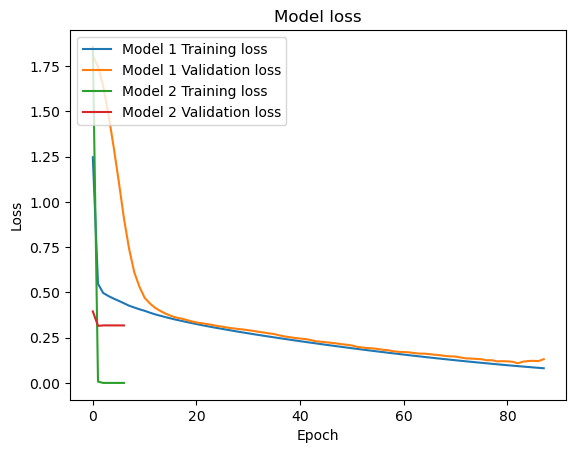

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Model 1 Training acc')
plt.plot(history.history['val_accuracy'], label='Model 1 Validation acc')
plt.plot(history_vgg16.history['accuracy'], label='Model 2 Training acc')
plt.plot(history_vgg16.history['val_accuracy'], label='Model 2 Validation acc')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Model 1 Training loss')
plt.plot(history.history['val_loss'], label='Model 1 Validation loss')
plt.plot(history_vgg16.history['loss'], label='Model 2 Training loss')
plt.plot(history_vgg16.history['val_loss'], label='Model 2 Validation loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()